# Partionining by Key in Milvus

#### 10-September-2024 == Partioned by Key with Milvus articles

# Goal of this Application

In this application, we will build a simple application to ingest recent Medium articles via RSS Feeds from Zilliz, Medium and Tim Spann.

### 1️⃣ Ingest and Parse RSS Feeds:
Learn to ingest data from three Medium RSS feeds and parse them with *feedparser*.   We also remove the HTML tags that are within the RSS Summary of the article

### 2️⃣ Store Data into Milvus:
Learn to store data into Milvus, an efficient vector database designed for high-speed similarity searches and AI applications.   In this step we are building a data model with scalar fields and a vector field.   This collection will be partitioned by media source.We have one large varchar field for the text of the article.   We encode the text with Sentence Transformer *all-MiniLM-L6-v2*.   

### 3️⃣ Search:
Discover how to use scalars and our vector to search data stored in Milvus show the final results in this notebook.

### 4️⃣ Display Resulting Text:
Build a quick output query filtered by partition key.

### 5️⃣ Examine Partitions:
We will inspect and validate the partitions that we have built in this application.  

# 🔍 Summary
By the end of this application, you’ll have a comprehensive understanding of using Milvus, data ingest object semi-structured and unstructured data, and using Open Source models to build a robust and efficient data retrieval system.   For future enhancements, we can use this information to feed a RAG or applications.


### Reference

https://milvus.io/docs/use-partition-key.md


## Partition by Key


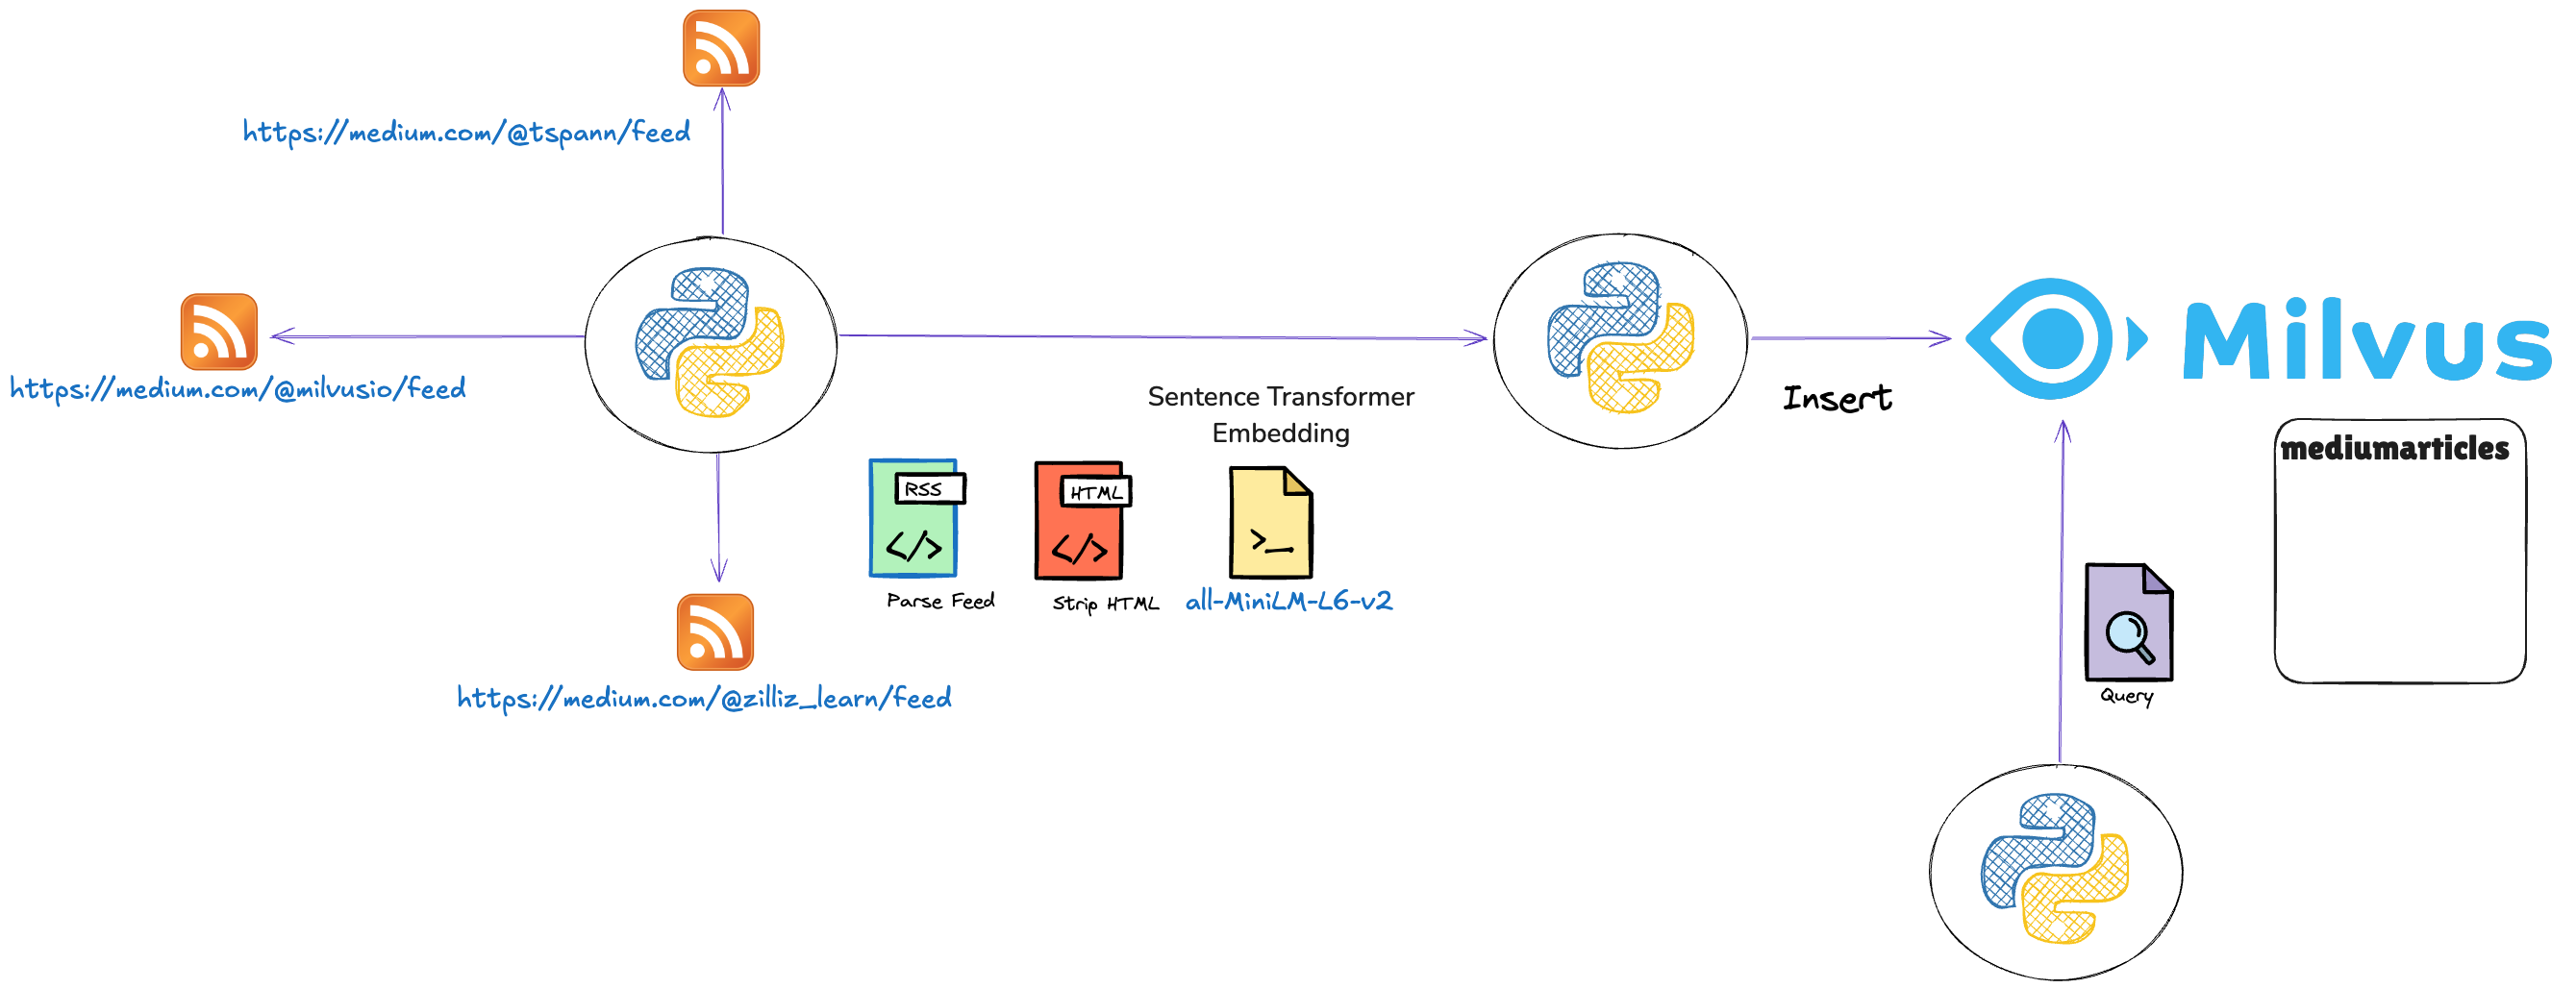

In [5]:
!pip3 install bs4 feedparser pymilvus[model]

In [14]:
import os
from pymilvus import MilvusClient
from pymilvus import (
   utility,
   FieldSchema, CollectionSchema, DataType,
   Collection, AnnSearchRequest, RRFRanker, connections, utility
)
from pymilvus import model
from pymilvus.model.dense import SentenceTransformerEmbeddingFunction

model = SentenceTransformerEmbeddingFunction('all-MiniLM-L6-v2',device='cpu' )

##### Three Medium blogs to consume from
TSPANN_SOURCE = "tspann"
MILVUS_SOURCE = "milvusio"
ZILLIZ_SOURCE = "zilliz_learn"

COLLECTION_NAME = "mediumarticleskey"
TSPANN_MEDIUM_URL = "https://medium.com/@" + TSPANN_SOURCE + "/feed"
MILVUS_MEDIUM_URL = "https://medium.com/@" + MILVUS_SOURCE + "/feed"
ZILLIZ_MEDIUM_URL = "https://medium.com/@" + ZILLIZ_SOURCE + "/feed"

# MILVUS_URL = "http://192.168.1.153:19530" 
MILVUS_URL = os.environ.get("SERVERLESS_VECTORDB_URI")
TOKEN = os.environ.get("ZILLIZ_TOKEN")

# Connect to Docker Server
milvus_client = MilvusClient( uri=MILVUS_URL, token=TOKEN )

/Users/timothyspann/Downloads/code/milvusvenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [52]:
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import pprint

if milvus_client.has_collection(COLLECTION_NAME):
    print("collection exists")
else:
    ## Schema
    # partition_key_field:   critical for partitioning
    # num_partitions:  default and best practice value is 16
    # 
    schema = milvus_client.create_schema(auto_id=True, enable_dynamic_fields=True, partition_key_field="doc_primary_category", num_partitions=16 )
    schema.add_field(field_name="doc_author", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_source", datatype=DataType.VARCHAR,  max_length=50)
    schema.add_field(field_name="doc_primary_category", datatype=DataType.VARCHAR, max_length=50)
    schema.add_field(field_name="doc_tags", datatype=DataType.VARCHAR, max_length=10000)
    schema.add_field(field_name="doc_id", datatype=DataType.VARCHAR, is_primary=True, max_length=100)
    schema.add_field(field_name="doc_title", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_link", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_publisheddate", datatype=DataType.VARCHAR,  max_length=100)
    schema.add_field(field_name="doc_text", datatype=DataType.VARCHAR, max_length=65535)
    schema.add_field(field_name="doc_embedding", datatype=DataType.FLOAT_VECTOR, dim=384)

    # Create the collection
    milvus_client.create_collection(
        collection_name=COLLECTION_NAME,
        schema=schema,
        description="Medium Articles by Key"
    )

    # Create index params
    index_params = [{"field_name": "doc_embedding","index_type": "IVF_FLAT","metric_type": "L2","params": {"nlist": 128}},
                    {"field_name": "doc_primary_category","index_type": "Trie"}]
    
    # Create index
    milvus_client.create_index(COLLECTION_NAME, index_params)

    # List all the partitions created for this collection
    res = milvus_client.list_partitions(collection_name=COLLECTION_NAME)
    print(res)

    # Get current load state for the collection
    # collections must be loaded into RAM for access
    res = milvus_client.get_load_state(
        collection_name = COLLECTION_NAME
    )
    
    print(res)


collection exists


In [48]:
import feedparser
from bs4 import BeautifulSoup

# Function to remove HTML tags
# TODO:   Use an LLM to convert to Markdown or Plain Text
# https://huggingface.co/jinaai/reader-lm-1.5b

def remove_tags(html):

    # parse html content
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [21]:
urls = [ TSPANN_MEDIUM_URL, MILVUS_MEDIUM_URL, ZILLIZ_MEDIUM_URL]
sources = {}
sources[ TSPANN_MEDIUM_URL ] = TSPANN_SOURCE
sources[ MILVUS_MEDIUM_URL ] = MILVUS_SOURCE
sources[ ZILLIZ_MEDIUM_URL ] = ZILLIZ_SOURCE

for url in urls:
    title = ""
    summary = ""
    link = ""
    publisheddate = ""
    author = ""
    tags = ""
    post = ""
    feed = ""
    docprimarycategory = ""
    feed = feedparser.parse(url)

    for post in feed.entries:
        try:
           # print(post)
           doc_source = str(sources[url])
           tags = ""

           docprimarycategory = str(post.tags[0].term)

           for tag in post.tags:
              tags = tags + str(tag.term) + ","
           author = str(post.author)
           summary = remove_tags(str(post.summary))
           title = str(post.title)
           link = str(post.link)
           publisheddate = str(post.published)
            
           entity = {
                "doc_source": doc_source,
                "doc_primary_category": docprimarycategory,
                "doc_author": author,
                "doc_tags": tags,
                "doc_title": title,
                "doc_link": link,
                "doc_publisheddate": publisheddate,
                "doc_text": summary,
                "doc_embedding": model(summary)
           }
           # Insert Entity into Milvus collection
           insert_result = milvus_client.insert(COLLECTION_NAME, [entity])
           print(f"Inserted document: {doc_source} {title}")
        except Exception as e: 
            print(e)

Inserted document: tspann AIM Weekly 09 Sept 2024
Inserted document: tspann Partitioning Collections by Name
Inserted document: tspann Report: Building the Future of Startups Enhanced with Vector Databases and AI
Inserted document: tspann AIM Weekly 02 September 2024
Inserted document: tspann Utilizing Multiple Vectors and Advanced Search Data Model Design for City Data
Inserted document: tspann AIM Weekly 26 August 2024
Inserted document: tspann AIM Weekly 19-August-2024
Inserted document: tspann What’s in the Air Tonight Mr. Milvus?
Inserted document: tspann Report: 15 August 2025 — AI Camp
Inserted document: tspann Report: AI and Vectors in The Sky
Inserted document: milvusio Introducing PyMilvus Integration with Embedding Models
Inserted document: milvusio Introducing Milvus Lite: Start Building a GenAI Application in Seconds
Inserted document: milvusio Getting started with Milvus cluster and K8s
Inserted document: milvusio Unveiling Milvus 2.4: Multi-vector Search, Sparse Vector, 

In [22]:
# Load the collection

milvus_client.load_collection(COLLECTION_NAME)

# Is the collection loaded?

res = milvus_client.get_load_state(
        collection_name = COLLECTION_NAME
)

print(res)

# Query the collection by scalar and display several fields, limit to 5 results
query_results = milvus_client.query(
    collection_name=COLLECTION_NAME,
    filter='doc_text like "%milvus%"',
    output_fields=["doc_embedding", "doc_tags","doc_title","doc_link","doc_text","doc_publisheddate", "doc_source"],
    limit=5
)

lastvector = None

# Display some of the data
# Grab a vector to use for search
for result in query_results:
    lastvector = result['doc_embedding']
    print(f"{result['doc_source']} : {result['doc_title']} <{result['doc_tags']}> on {result['doc_publisheddate']} {result['doc_link']}\n")

{'state': <LoadState: Loaded>}
tspann : AIM Weekly 02 September 2024 <ai,genai,open-source,vector-database,milvus,> on Tue, 03 Sep 2024 16:50:29 GMT https://medium.com/@tspann/aim-weekly-02-september-2024-07d67dfa3b17?source=rss-13e1ea7cf9ee------2

tspann : Utilizing Multiple Vectors and Advanced Search Data Model Design for City Data <open-source,ai,vector-database,milvus,rags,> on Thu, 29 Aug 2024 15:04:37 GMT https://medium.com/@tspann/utilizing-multiple-vectors-and-advanced-search-data-model-design-for-city-data-705d68d8daf2?source=rss-13e1ea7cf9ee------2

tspann : AIM Weekly 26 August 2024 <vector-database,open-source,milvus,ai,genai,> on Tue, 27 Aug 2024 15:31:47 GMT https://medium.com/@tspann/aim-weekly-26-august-2024-5337c4fb65e4?source=rss-13e1ea7cf9ee------2

tspann : AIM Weekly 19-August-2024 <vector-database,open-source,genai,ai,milvus,> on Mon, 19 Aug 2024 14:33:11 GMT https://medium.com/@tspann/aim-weekly-19-august-2024-503acf97c302?source=rss-13e1ea7cf9ee------2

tspann

In [49]:
import time

# Run a start and end time for our search
# Search collection vector from above
t0 = time.time()

search_results = milvus_client.search(
    collection_name=COLLECTION_NAME,
    data=[lastvector],
    filter='doc_primary_category in ["milvus","open-source","vector-database"]',
    output_fields=["doc_primary_category", "doc_tags","doc_title","doc_link","doc_publisheddate","doc_text", "doc_source"],
    search_params={"metric_type": "L2", "params": {"nprobe": 10}},
    limit=5
)

t1 = time.time()
print(f"search latency: {round(t1-t0, 4)} seconds\n\n")
print( '-----------------------------------------------------------------------------------------------------------')

# -----------------------------------------------------------------------------
# Iterate through last <limit> results and display scalars
# -----------------------------------------------------------------------------
for result in search_results:
    for hit in result[:5]:
        #  --- print(hit)
        print( "Distance: >> " + str(hit["distance"]) + " <<  ID:" + str(hit["id"]) )
        print( "Partition Key: [" + hit["entity"]["doc_primary_category"] + "] Tags: " + hit["entity"]["doc_tags"] )
        print( "Title: " + hit["entity"]["doc_title"] )
        print( "Link: " + hit["entity"]["doc_link"] )
        print( "Source: " + hit["entity"]["doc_source"] )
        print( '-----------------------------------------------------------------------------------------------------------')
        

search latency: 0.1313 seconds


-----------------------------------------------------------------------------------------------------------
Distance: >> 0.0 <<  ID:452498223031342184
Partition Key: [open-source] Tags: open-source,generative-ai-use-cases,milvus,air-quality,vector-database,
Title: What’s in the Air Tonight Mr. Milvus?
Link: https://medium.com/@tspann/whats-in-the-air-tonight-mr-milvus-fbd42f06e482?source=rss-13e1ea7cf9ee------2
Source: tspann
-----------------------------------------------------------------------------------------------------------
Distance: >> 1.2359179258346558 <<  ID:452498223031342182
Partition Key: [vector-database] Tags: vector-database,open-source,genai,ai,milvus,
Title: AIM Weekly 19-August-2024
Link: https://medium.com/@tspann/aim-weekly-19-august-2024-503acf97c302?source=rss-13e1ea7cf9ee------2
Source: tspann
-----------------------------------------------------------------------------------------------------------
Distance: >> 1.2659069299697

In [50]:
# Query the collection for count
res = milvus_client.query(
    collection_name=COLLECTION_NAME,
    output_fields=["count(*)"]
)

print(res)

data: ["{'count(*)': 30}"] , extra_info: {'cost': 6}


In [51]:
# Get load state for entire collection
res = milvus_client.get_load_state(collection_name=COLLECTION_NAME)
print(res)

# Get load state for one of the partitions
res = milvus_client.get_load_state(collection_name=COLLECTION_NAME, partition_name='_default_15')
print(res)

# List all the partitions for the collection
res = milvus_client.list_partitions(collection_name=COLLECTION_NAME)
print(res)

{'state': <LoadState: Loaded>}
{'state': <LoadState: Loaded>}
['_default_0', '_default_1', '_default_2', '_default_3', '_default_4', '_default_5', '_default_6', '_default_7', '_default_8', '_default_9', '_default_10', '_default_11', '_default_12', '_default_13', '_default_14', '_default_15']
